# News analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from collections import Counter
from wordcloud import WordCloud
import geopandas as gpd
import plotly.express as px
import spacy
import srsly
import numpy as np

## Cleaning

In [10]:
articles = pd.read_csv('helene_articles_20241114.csv')

# - date: string to date.time
articles['date'] = pd.to_datetime(articles['date'])

# - author & word_count: fill_na 
articles = articles.fillna('')

# Function to clean article texts
def clean_text(text):
    newspaper = articles.loc[articles['article'] == text,'newspaper'].iloc[0]
    # Remove "All rights reserved"
    text = re.sub(r"\n.*?All Rights Reserved\..*", "", text)
    text = re.sub(r"\n.*?All rights reserved\..*", "", text)
    # Remove "Citation (aglc Style)..." at the end of the articles
    text = re.sub(r"Citation \(aglc Style\)\n.*", "", text, flags=re.DOTALL)
    # Remove last news outlet occurance
    text = text.split(newspaper, -1)[0]

    # Convert to lowercase
    # text = text.lower()  
    # Remove punctuation and special characters
    # text = re.sub(r'\W+', ' ', text)  
    return text

articles['article_text'] = articles['article'].apply(clean_text)

# Save it locally
articles.to_csv('helene_articles_cleaned.csv', index= False)
articles.head()

,header,article,title,date,newspaper,author,word_count,County,Outlet,article_text
0,"Samaritan’s Purse, Alliance Bible Fellowship e...",BOONE — Samaritan's Purse and Alliance Bible F...,"Samaritan’s Purse, Alliance Bible Fellowship e...",2024-10-02,Watauga Democrat,Luke Barber luke.barber@wataugademocrat.com,593.0,Watauga,Watauga Democrat,BOONE — Samaritan's Purse and Alliance Bible F...
1,Watch out for scammers as recovery efforts mov...,Attorney General Josh Stein declared the state...,Watch out for scammers as recovery efforts mov...,2024-10-02,Watauga Democrat,Ben McNeely,379.0,Watauga,Watauga Democrat,Attorney General Josh Stein declared the state...
2,STORM RECOVERY: Carbon Monoxide Safety\nOctobe...,Widespread power outages due to damage from Hu...,STORM RECOVERY: Carbon Monoxide Safety,2024-10-02,Watauga Democrat,Staff Writer,440.0,Watauga,Watauga Democrat,Widespread power outages due to damage from Hu...
3,Outage restoration continues with more than 40...,More than 300 line technicians consisting of B...,Outage restoration continues with more than 40...,2024-10-02,Watauga Democrat,Moss Brennan moss.brennan@wataugademocrat.com,267.0,Watauga,Watauga Democrat,More than 300 line technicians consisting of B...
4,"Charlotte Observer, The (NC): Page 1\nOctober ...","Citation (aglc Style)\nCharlotte Observer, The...","Charlotte Observer, The (NC): Page 1",2024-10-02,Charlotte Observer,,,Mecklenburg,Charlotte Observer,


## Analysis

A few research questions to ask:
1. How has the coverage topic changed along time?
2. In which geographical areas are these coverages about, how local are these coverages?
3. service media: how much of them touched on action to do or support?
4. Tone of the news reporting: sentiment analysis?
5. How satisfied are people in disaster about these coverages: survey?

In [3]:
# Read articles after cleaning
articles = pd.read_csv('helene_articles_cleaned.csv').fillna("")

In [4]:
# Get a subset of valid articles because we don't have all
sub_articles = articles[articles['word_count'] != '']

In [13]:
from nltk.stem import PorterStemmer

# Lowercase and remove special characters
def lower_and_remove_special(text):
    # Convert to lowercase
    text = text.lower()  
    # Remove punctuation and special characters
    text = re.sub(r'\W+', ' ', text)
    return text  

# Stem
stemmer = PorterStemmer()
def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

# Download stop words
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Another stop word set for news
stop_df = pd.read_csv('https://raw.githubusercontent.com/vikasing/news-stopwords/refs/heads/master/sw10k.csv')
stop_words.update(stop_df['term'].to_list())
# Because this is all about hurricane helene, remove them as stop-words
stop_words.update(['2024', 'hurricane', 'helene'])

# Tokenize and remove stop words
def tokenize_and_remove_stopwords(text):
    words = word_tokenize(text)
    return [word for word in words if word not in stop_words]

[nltk_data] Downloading package punkt to /Users/yanans/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yanans/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Lower and remove special characters
sub_articles['cleaned_text'] = sub_articles['article_text'].apply(lower_and_remove_special)
# Remove stop words
sub_articles['tokens'] = sub_articles['cleaned_text'].apply(tokenize_and_remove_stopwords)
# Stem the tokens
# sub_articles['stemmed_tokens'] = sub_articles['tokens'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])
sub_articles['stemmed_tokens'] = sub_articles['tokens'].apply(stem_tokens)

### Coverage number changes

In [10]:
date = articles.groupby('date')['article'].count().reset_index()
date

,date,article
0,2024-09-23,2
1,2024-09-24,3
2,2024-09-25,17
3,2024-09-26,32
4,2024-09-27,40
5,2024-09-28,26
6,2024-09-29,43
7,2024-09-30,50
8,2024-10-01,86
9,2024-10-02,126


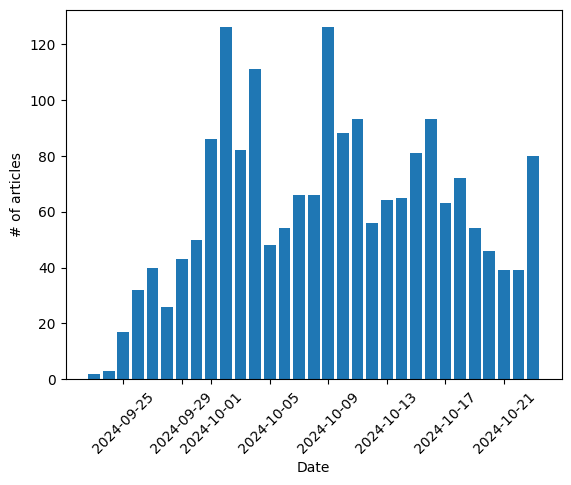

In [17]:
# Plotting the data
plt.bar(date['date'], date['article'])
plt.xlabel('Date')
plt.ylabel('# of articles')
plt.xticks(rotation=45)

# plt.title('')
plt.show()

### Word frenquency analysis

Before getting news articles texts for print, analyze only the subset of it with valid texts

In [16]:
# Flatten all tokens into a single list and count frequencies
all_tokens = [token for tokens in sub_articles['tokens'] for token in tokens]
word_freq = Counter(all_tokens)
print(word_freq.most_common(50))  # Display the 10 most common words

[('asheville', 1423), ('fema', 1323), ('nc', 886), ('watauga', 616), ('mcdowell', 606), ('haywood', 522), ('boone', 509), ('buncombe', 399), ('catawba', 390), ('caldwell', 385), ('devastation', 360), ('henderson', 344), ('marion', 341), ('waynesville', 326), ('outages', 288), ('rutherford', 286), ('hendersonville', 282), ('downed', 267), ('canton', 266), ('morganton', 262), ('polk', 260), ('828', 249), ('biden', 243), ('touchdown', 242), ('baptist', 238), ('chimney', 214), ('ashe', 212), ('hurricanes', 210), ('halloween', 205), ('hickory', 199), ('avery', 193), ('appalachian', 192), ('responders', 191), ('swannanoa', 191), ('pisgah', 184), ('biltmore', 178), ('wnc', 178), ('cleanup', 172), ('cherokee', 169), ('tryon', 169), ('gaston', 166), ('absentee', 162), ('milton', 160), ('touchdowns', 154), ('3a', 153), ('2025', 149), ('remnants', 146), ('pine', 140), ('parkway', 136), ('shelters', 136)]


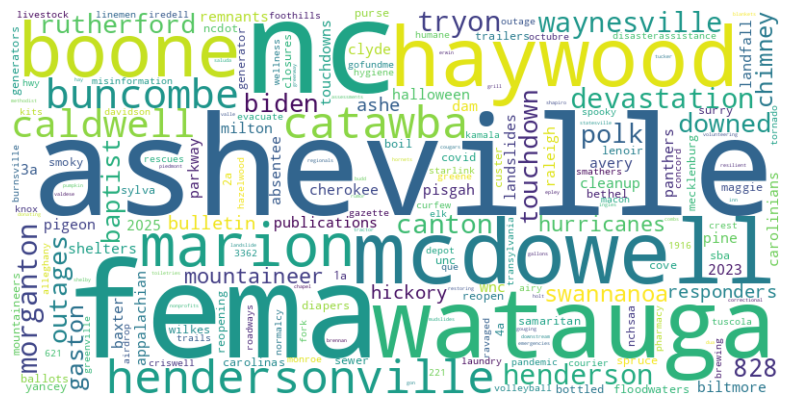

In [69]:
# Create the word cloud from the frequency dictionary
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Most frequent words are county names / locations. Others are description of the disaster such as "devastation", "outages", "downed", "landslides", ...

Something that didn't make sense: "baptist", "touchdown(s)"

### Topic modeling

Use BERTransformer for topic modeling

In [5]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

/Users/yanans/Desktop/helene_coverage/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
sub_articles.head()

,header,article,title,date,newspaper,author,word_count,County,Outlet,article_text,cleaned_text,tokens,stemmed_tokens
0,"Samaritan’s Purse, Alliance Bible Fellowship e...",BOONE — Samaritan's Purse and Alliance Bible F...,"Samaritan’s Purse, Alliance Bible Fellowship e...",2024-10-02,Watauga Democrat,Luke Barber luke.barber@wataugademocrat.com,593.0,Watauga,Watauga Democrat,BOONE — Samaritan's Purse and Alliance Bible F...,boone samaritan s purse and alliance bible fel...,"[boone, samaritan, purse, fellowship, 1035, hw...","[boon, samaritan, purs, fellowship, 1035, hwi,..."
1,Watch out for scammers as recovery efforts mov...,Attorney General Josh Stein declared the state...,Watch out for scammers as recovery efforts mov...,2024-10-02,Watauga Democrat,Ben McNeely,379.0,Watauga,Watauga Democrat,Attorney General Josh Stein declared the state...,attorney general josh stein declared the state...,"[stein, gouging, landfall, activated, declares...","[stein, goug, landfal, activ, declar, unreason..."
2,STORM RECOVERY: Carbon Monoxide Safety\nOctobe...,Widespread power outages due to damage from Hu...,STORM RECOVERY: Carbon Monoxide Safety,2024-10-02,Watauga Democrat,Staff Writer,440.0,Watauga,Watauga Democrat,Widespread power outages due to damage from Hu...,widespread power outages due to damage from hu...,"[outages, boone, monoxide, poisoning, applianc...","[outag, boon, monoxid, poison, applianc, gener..."
3,Outage restoration continues with more than 40...,More than 300 line technicians consisting of B...,Outage restoration continues with more than 40...,2024-10-02,Watauga Democrat,Moss Brennan moss.brennan@wataugademocrat.com,267.0,Watauga,Watauga Democrat,More than 300 line technicians consisting of B...,more than 300 line technicians consisting of b...,"[technicians, consisting, cooperatives, gradin...","[technician, consist, cooper, grade, categor, ..."
12,Virginia commit Hamrick returning to Crest Hig...,University of Virginia recruit and A.C. Reynol...,Virginia commit Hamrick returning to Crest Hig...,2024-10-10,Gaston Gazette,Joe L Hughes II; Shelby Star,344.0,Gaston,The Gaston Gazette,University of Virginia recruit and A.C. Reynol...,university of virginia recruit and a c reynold...,"[ely, hamrick, crest, crest, crest, asheville,...","[eli, hamrick, crest, crest, crest, ashevil, b..."


##### BERTopic

is an <a href = 'https://maartengr.github.io/BERTopic/index.html#quick-start'>open-source library</a> by hugging face to analyze and extract topics and possibilities

In [ ]:
# Use tokens without stop-words
tokens = sub_articles.tokens.apply(lambda x: " ".join(x))
tokens 

0       boone samaritan purse fellowship 1035 hwy bypa...
1       stein gouging landfall activated declares unre...
2       outages boone monoxide poisoning appliances ge...
3       technicians consisting cooperatives grading ca...
12      ely hamrick crest crest crest asheville buncom...
                              ...                        
1906    hendersonville resilient hendersonville volk w...
1907    thanksgiving figuring fixe carte selections th...
1908    heartbroken disturbed floodwaters dwelling ren...
1909    distinguished rutherford distinguished rutherf...
1910    apples timey apples orchard descriptions apple...
Name: tokens, Length: 1679, dtype: object

In [ ]:
# Load the model (default uses all-MiniLM-L6-v2 embeddings)
topic_model = BERTopic()

# Fit the model to news articles' tokens
topics, probs = topic_model.fit_transform(tokens)

# View the topics
print(topic_model.get_topic_info())

    Topic  Count                                       Name  \
0      -1    505              -1_asheville_nc_watauga_boone   
1       0    163           0_touchdown_touchdowns_3a_nchsaa   
2       1     72                 1_boone_watauga_valle_holt   
3       2     57            2_kelsey_mancini_usda_livestock   
4       3     53       3_fema_custer_sba_disasterassistance   
5       4     50            4_mcdowell_marion_effler_biffle   
6       5     50            5_landslides_quartz_spruce_pine   
7       6     48            6_outages_downed_outage_linemen   
8       7     41   7_rutherford_chimney_rutherfordton_leary   
9       8     41                  8_nc_donna_bonnell_monroe   
10      9     37                 9_polk_tryon_mears_heavner   
11     10     36        10_pandemic_covid_turbovsky_cortman   
12     11     33         11_biden_kamala_carolinians_tillis   
13     12     32         12_hurricanes_landfall_milton_kirk   
14     13     28   13_contaminated_vibrio_sewage_vulnif

There are 41 categories, which includes one outlier (denoted by -1 and mostly are less related to Hurricane Helene)

❓Include these into the dataset or not?

In [50]:
# Get info on a document level
topic_model.get_document_info(tokens)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,boone samaritan purse fellowship 1035 hwy bypa...,1,1_boone_watauga_valle_holt,"[boone, watauga, valle, holt, crucis, futrelle...",[watauga avery devastation 46th valle episcopa...,boone - watauga - valle - holt - crucis - futr...,0.648801,False
1,stein gouging landfall activated declares unre...,24,24_scammers_gouging_scams_cody,"[scammers, gouging, scams, cody, rork, stein, ...",[cody asheville hurricanes tornadoes dishonest...,scammers - gouging - scams - cody - rork - ste...,0.341811,False
2,outages boone monoxide poisoning appliances ge...,6,6_outages_downed_outage_linemen,"[outages, downed, outage, linemen, blueridgeen...",[manpower technicians graders watauga ashe 535...,outages - downed - outage - linemen - blueridg...,0.460316,False
3,technicians consisting cooperatives grading ca...,-1,-1_asheville_nc_watauga_boone,"[asheville, nc, watauga, boone, swannanoa, bun...",[afar charlottefive charlottefive bearings dev...,asheville - nc - watauga - boone - swannanoa -...,0.000000,False
4,ely hamrick crest crest crest asheville buncom...,0,0_touchdown_touchdowns_3a_nchsaa,"[touchdown, touchdowns, 3a, nchsaa, 2a, panthe...",[previews gaston kickoff crest crest 3a nfhs w...,touchdown - touchdowns - 3a - nchsaa - 2a - pa...,1.000000,False
...,...,...,...,...,...,...,...,...
1674,hendersonville resilient hendersonville volk w...,25,25_hendersonville_828_henderson_asheville,"[hendersonville, 828, henderson, asheville, ph...",[toiletries hubs etowah 320 etowah etowah 3345...,hendersonville - 828 - henderson - asheville -...,0.934602,False
1675,thanksgiving figuring fixe carte selections th...,8,8_nc_donna_bonnell_monroe,"[nc, donna, bonnell, monroe, thanksgiving, bre...",[thanksgiving figuring fixe carte selections t...,nc - donna - bonnell - monroe - thanksgiving -...,0.967591,True
1676,heartbroken disturbed floodwaters dwelling ren...,-1,-1_asheville_nc_watauga_boone,"[asheville, nc, watauga, boone, swannanoa, bun...",[afar charlottefive charlottefive bearings dev...,asheville - nc - watauga - boone - swannanoa -...,0.000000,False
1677,distinguished rutherford distinguished rutherf...,7,7_rutherford_chimney_rutherfordton_leary,"[rutherford, chimney, rutherfordton, leary, fa...",[rutherford rutherford avenues rutherford chim...,rutherford - chimney - rutherfordton - leary -...,1.000000,False


In [53]:
print(topic_model.get_topic(11)) 

[('biden', np.float64(0.06347918980393676)), ('kamala', np.float64(0.05769370652921589)), ('carolinians', np.float64(0.04626951920488967)), ('tillis', np.float64(0.038626733523479645)), ('reassurance', np.float64(0.027260022992862454)), ('usher', np.float64(0.024999384255895627)), ('concord', np.float64(0.024443027339914967)), ('grapple', np.float64(0.024380068097578887)), ('pamlico', np.float64(0.023049273043197156)), ('greenville', np.float64(0.021686302109317854))]


Use the original article texts (with stop-words)

In [ ]:

# Fit the model to your news articles
topics, probs = topic_model.fit_transform(sub_articles['article_text'])

# View the topics
print(topic_model.get_topic_info())

# Visualize topics (Optional, generates an interactive plot in a browser)
# topic_model.visualize_topics()

# Extract representative keywords for a topic
print(topic_model.get_topic(5))  # Replace 0 with your topic number

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    Topic  Count                                      Name  \
0      -1    473                          -1_the_and_to_of   
1       0     98                       0_yards_on_the_game   
2       1     76                        1_boone_and_to_the   
3       2     55                          2_the_and_her_he   
4       3     46                     3_power_energy_to_and   
5       4     44                  4_music_concert_the_will   
6       5     43                           5_the_to_is_and   
7       6     38            6_rutherford_lure_lake_chimney   
8       7     38           7_voting_early_voters_elections   
9       8     36                 8_bus_school_route_normal   
10      9     35               9_hurricane_storm_the_coast   
11     10     34                 10_location_and_nc_strike   
12     11     34                     11_tryon_polk_and_the   
13     12     34           12_halloween_waynesville_pm_oct   
14     13     33                  13_water_asheville_or_to   
15     1

Try change another model: KeyBERTInspired, to increases the coherence and reduce stopwords

With tokens

In [ ]:
from bertopic.representation import KeyBERTInspired

representation_model = KeyBERTInspired()
topic_model_1 = BERTopic(representation_model=representation_model)

# Fit the model to your news articles
topics, probs = topic_model_1.fit_transform(tokens)

# View the topics
print(topic_model_1.get_topic_info())

    Topic  Count                                               Name  \
0      -1    490               -1_shelters_nc_asheville_waynesville   
1       0    165      0_mountaineers_piedmont_mecklenburg_morganton   
2       1     72      1_worm_worms_valle_wataugacountyfarmersmarket   
3       2     71                      2_livestock_cows_tractor_corn   
4       3     53  3_fema_custer_disastercustomerservice_disaster...   
5       4     50      4_landslides_landslide_wilderness_appalachian   
6       5     47            5_mcdowellcares_mcdowell_shelters_motel   
7       6     41  6_rutherfordcountync_rutherford_chimney_ruther...   
8       7     40              7_pandemic_covid_supermarkets_freezer   
9       8     38            8_outage_outages_technician_technicians   
10      9     38          9_bakersville_diners_marshville_cornbread   
11     10     36                 10_polk_polknc_evacuations_outages   
12     11     34      11_hurricanes_landfall_cyclones_thunderstorms   
13    

In [63]:
topic_labels_3 = topic_model.get_document_info(tokens)
topic_labels_3.head()


,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,boone samaritan purse fellowship 1035 hwy bypa...,1,1_worm_worms_valle_wataugacountyfarmersmarket,"[worm, worms, valle, wataugacountyfarmersmarke...",[watauga avery devastation 46th valle episcopa...,worm - worms - valle - wataugacountyfarmersmar...,0.605308,False
1,stein gouging landfall activated declares unre...,21,21_scammers_scams_scammed_fraudsters,"[scammers, scams, scammed, fraudsters, fraudul...",[cody asheville hurricanes tornadoes dishonest...,scammers - scams - scammed - fraudsters - frau...,0.302180,False
2,outages boone monoxide poisoning appliances ge...,8,8_outage_outages_technician_technicians,"[outage, outages, technician, technicians, sub...",[technicians outages 837 linemen downed mangle...,outage - outages - technician - technicians - ...,0.872066,False
3,technicians consisting cooperatives grading ca...,-1,-1_shelters_nc_asheville_waynesville,"[shelters, nc, asheville, waynesville, boone, ...",[remnants mcdowell catawba iredell shelters nc...,shelters - nc - asheville - waynesville - boon...,0.000000,False
4,ely hamrick crest crest crest asheville buncom...,0,0_mountaineers_piedmont_mecklenburg_morganton,"[mountaineers, piedmont, mecklenburg, morganto...",[previews gaston kickoff crest crest 3a nfhs w...,mountaineers - piedmont - mecklenburg - morgan...,1.000000,False


In [64]:
topic_labels_3['Document'][3]

'technicians consisting cooperatives grading categorized rebuilt sawing devasted vegetation cutoff diligently arteries redundant backfeed outage caldwell watauga ashe alleghany avery wilkes blueridgeenergy'

With original article texts

In [ ]:
from bertopic.representation import KeyBERTInspired

representation_model = KeyBERTInspired()
topic_model_1 = BERTopic(representation_model=representation_model)

# Fit the model to your news articles
topics, probs = topic_model_1.fit_transform(sub_articles['article_text'])

# View the topics
print(topic_model_1.get_topic_info())

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


NameError: name 'topic_model' is not defined

Seems to be better with original texts

In [8]:
print(topic_model_1.get_topic_info())

    Topic  Count                                               Name  \
0      -1    429              -1_hurricane_asheville_carolina_storm   
1       0    168              0_panthers_yards_touchdowns_touchdown   
2       1     87                  1_hurricane_fema_disaster_funding   
3       2     71               2_boone_appalachian_hurricane_helene   
4       3     63           3_schools_mcdowell_superintendent_school   
5       4     46                        4_ridge_storm_outages_power   
6       5     38                   5_ballots_ballot_elections_voter   
7       6     37                      6_chimney_lure_lake_hurricane   
8       7     36                    7_hurricane_nc_carolina_funding   
9       8     36                        8_hurricane_flooding_nc_hwy   
10      9     34                9_hurricane_hurricanes_storms_storm   
11     10     33            10_halloween_haywood_hazelwood_hayrides   
12     11     32               11_asheville_carolina_buncombe_water   
13    

In [11]:
topic_model_1.get_document_info(sub_articles['article_text']).head()


,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,BOONE — Samaritan's Purse and Alliance Bible F...,-1,-1_hurricane_asheville_carolina_storm,"[hurricane, asheville, carolina, storm, disast...","[ASHEVILLE, N.C. — If she had known the rivers...",hurricane - asheville - carolina - storm - dis...,0.000000,False
1,Attorney General Josh Stein declared the state...,30,30_hurricane_contractors_contractor_insurance,"[hurricane, contractors, contractor, insurance...","[""Never pay a big deposit up front. Always hav...",hurricane - contractors - contractor - insuran...,0.766946,False
2,Widespread power outages due to damage from Hu...,2,2_boone_appalachian_hurricane_helene,"[boone, appalachian, hurricane, helene, town, ...",[As Western North Carolina recovers from the d...,boone - appalachian - hurricane - helene - tow...,1.000000,False
3,More than 300 line technicians consisting of B...,4,4_ridge_storm_outages_power,"[ridge, storm, outages, power, carolina, resto...",[Following widespread devastation in Western N...,ridge - storm - outages - power - carolina - r...,0.873940,False
4,University of Virginia recruit and A.C. Reynol...,0,0_panthers_yards_touchdowns_touchdown,"[panthers, yards, touchdowns, touchdown, rushi...",[The Pisgah Bears football team returned to ac...,panthers - yards - touchdowns - touchdown - ru...,1.000000,False


In [12]:
labels_1 = topic_model_1.get_document_info(sub_articles['article_text'])
labels_1['Probability'].describe()

count    1679.000000
mean        0.640704
std         0.419418
min         0.000000
25%         0.000000
50%         0.880968
75%         1.000000
max         1.000000
Name: Probability, dtype: float64

In [14]:
len(labels_1[labels_1['Probability'] <1])

991

In [16]:
labels_1[(labels_1['Probability'] <1) & (labels_1['Probability'] >0)]

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
1,Attorney General Josh Stein declared the state...,30,30_hurricane_contractors_contractor_insurance,"[hurricane, contractors, contractor, insurance...","[""Never pay a big deposit up front. Always hav...",hurricane - contractors - contractor - insuran...,0.766946,False
3,More than 300 line technicians consisting of B...,4,4_ridge_storm_outages_power,"[ridge, storm, outages, power, carolina, resto...",[Following widespread devastation in Western N...,ridge - storm - outages - power - carolina - r...,0.873940,False
5,Gaston is one of 25 North Carolina counties ap...,20,20_fema_disasterassistancegov_disaster_aid,"[fema, disasterassistancegov, disaster, aid, i...","[If you live in Florida, Georgia, North Caroli...",fema - disasterassistancegov - disaster - aid ...,0.766254,False
6,"TALLAHASSEE, Fla. – Florida Attorney General A...",30,30_hurricane_contractors_contractor_insurance,"[hurricane, contractors, contractor, insurance...","[""Never pay a big deposit up front. Always hav...",hurricane - contractors - contractor - insuran...,0.840937,False
9,"For Western North Carolina, October is typical...",13,13_nc_carolina_ncdot_asheville,"[nc, carolina, ncdot, asheville, highway, repa...",[Crews across western North Carolina are worki...,nc - carolina - ncdot - asheville - highway - ...,0.614697,False
...,...,...,...,...,...,...,...,...
1672,Nearly a month after Hurricane Helene swept th...,33,33_biltmore_biltmores_asheville_hurricane,"[biltmore, biltmores, asheville, hurricane, he...",[Biltmore Estate is set to reopen after damage...,biltmore - biltmores - asheville - hurricane -...,0.481973,False
1674,As Hurricane Helene passed through Western Nor...,12,12_restaurants_restaurant_charlotte_supplies,"[restaurants, restaurant, charlotte, supplies,...",[As thousands of people are picking up the pie...,restaurants - restaurant - charlotte - supplie...,0.835191,False
1676,As I visit many of the western North Carolina ...,7,7_hurricane_nc_carolina_funding,"[hurricane, nc, carolina, funding, disaster, c...",[RALEIGH North Carolina's lawmakers moved quic...,hurricane - nc - carolina - funding - disaster...,0.786803,False
1677,Ongoing events\nDistinguished Young Women of R...,6,6_chimney_lure_lake_hurricane,"[chimney, lure, lake, hurricane, storm, river,...","[CHIMNEY ROCK For a while on Friday morning, i...",chimney - lure - lake - hurricane - storm - ri...,0.469360,False


In [17]:
check = labels_1[(labels_1['Probability'] <1) & (labels_1['Probability'] >0)]
check.to_csv("tags_to_check.csv", index=False)

**Try with OpenAI API**?

Turn these topics into broader categories

In [ ]:
topic_labels_4 = topic_model.get_document_info(sub_articles['article_text'])
topic_labels_4.head()

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,BOONE — Samaritan's Purse and Alliance Bible F...,22,22_church_churches_bethel_churchs,"[church, churches, bethel, churchs, pastor, ba...",[It has been a very long week. What began as a...,church - churches - bethel - churchs - pastor ...,0.577781,False
1,Attorney General Josh Stein declared the state...,33,33_contractors_contractor_insurance_disaster,"[contractors, contractor, insurance, disaster,...","[""Never pay a big deposit up front. Always hav...",contractors - contractor - insurance - disaste...,0.799763,False
2,Widespread power outages due to damage from Hu...,0,0_boone_appalachian_hurricane_helene,"[boone, appalachian, hurricane, helene, storm,...",[As Western North Carolina recovers from the d...,boone - appalachian - hurricane - helene - sto...,1.000000,False
3,More than 300 line technicians consisting of B...,4,4_ridge_storm_outages_substations,"[ridge, storm, outages, substations, power, ca...",[Following widespread devastation in Western N...,ridge - storm - outages - substations - power ...,1.000000,False
4,University of Virginia recruit and A.C. Reynol...,-1,-1_hurricane_asheville_storm_carolina,"[hurricane, asheville, storm, carolina, helene...","[HIGH COUNTRY — For some, the connection to th...",hurricane - asheville - storm - carolina - hel...,0.000000,False


In [ ]:
topic_labels_4[topic_labels_4["Topic"] == -1]

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
4,University of Virginia recruit and A.C. Reynol...,-1,-1_hurricane_asheville_storm_carolina,"[hurricane, asheville, storm, carolina, helene...","[HIGH COUNTRY — For some, the connection to th...",hurricane - asheville - storm - carolina - hel...,0.0,False
10,I continue to be shocked and heartbroken by th...,-1,-1_hurricane_asheville_storm_carolina,"[hurricane, asheville, storm, carolina, helene...","[HIGH COUNTRY — For some, the connection to th...",hurricane - asheville - storm - carolina - hel...,0.0,False
16,Franklin football will wear a special helmet s...,-1,-1_hurricane_asheville_storm_carolina,"[hurricane, asheville, storm, carolina, helene...","[HIGH COUNTRY — For some, the connection to th...",hurricane - asheville - storm - carolina - hel...,0.0,False
20,Henderson County remains in a State of Emergen...,-1,-1_hurricane_asheville_storm_carolina,"[hurricane, asheville, storm, carolina, helene...","[HIGH COUNTRY — For some, the connection to th...",hurricane - asheville - storm - carolina - hel...,0.0,False
22,SWANNANOA – Sitting on the front porch of the ...,-1,-1_hurricane_asheville_storm_carolina,"[hurricane, asheville, storm, carolina, helene...","[HIGH COUNTRY — For some, the connection to th...",hurricane - asheville - storm - carolina - hel...,0.0,False
...,...,...,...,...,...,...,...,...
1659,Stone Mtn State Park will be closed at least u...,-1,-1_hurricane_asheville_storm_carolina,"[hurricane, asheville, storm, carolina, helene...","[HIGH COUNTRY — For some, the connection to th...",hurricane - asheville - storm - carolina - hel...,0.0,False
1660,"Such a helpless, odd - yet tinged with awe - f...",-1,-1_hurricane_asheville_storm_carolina,"[hurricane, asheville, storm, carolina, helene...","[HIGH COUNTRY — For some, the connection to th...",hurricane - asheville - storm - carolina - hel...,0.0,False
1661,One of Miss Letitia Currie's favorite topics i...,-1,-1_hurricane_asheville_storm_carolina,"[hurricane, asheville, storm, carolina, helene...","[HIGH COUNTRY — For some, the connection to th...",hurricane - asheville - storm - carolina - hel...,0.0,False
1668,North Carolina is still adding up the damage d...,-1,-1_hurricane_asheville_storm_carolina,"[hurricane, asheville, storm, carolina, helene...","[HIGH COUNTRY — For some, the connection to th...",hurricane - asheville - storm - carolina - hel...,0.0,False


In [ ]:
topic_labels_4['Document'][1669]

'People in Clyde were rebuilding Saturday — again.\nFor many residents, it was their second time getting hit by a storm and having to start over. For some, it was the\nthird. In 2021, Haywood County got hit by Tropical Storm Fred. Before that, Ivan in 2004.\nRAL_092822-HURRICANE-HELENE-TEL-33.JPGA North Carolina flag llies in the mud in Clyde on Saturday, Sept. 28,\n2024 after massive flooding damaged dozens of homes and businesses. The remnants of Hurricane Helene caused\nwidespread flooding, downed trees, and power outages in western North Carolina.\nBut neither compared to what they saw after Helene, residents told The '

Looks like with the original text, clustering and embeddings are better

In [ ]:
## TODO

def categorize_topics():
    

##### Keywords extraction + topic modeling

Get sentence keywords with BERT transformer

In [68]:
from keybert import KeyBERT

# Load the KeyBERT model
model = KeyBERT()

# Extract keywords from an article
keywords = model.extract_keywords(sub_articles['cleaned_text'][3], keyphrase_ngram_range=(1, 2), stop_words='english')

print(keywords)

[('blue ridge', 0.4526), ('energy crews', 0.4525), ('supporting restoration', 0.4268), ('neighborhoods crews', 0.4056), ('power service', 0.3989)]


In [47]:
# Extract keywords from an article
keywords = model.extract_keywords(" ".join(sub_articles['stemmed_tokens'][3]), keyphrase_ngram_range=(1, 2), stop_words='english')

print(keywords)

[('rebuilt saw', 0.6123), ('technician consist', 0.5595), ('technician', 0.5317), ('saw', 0.4373), ('rebuilt', 0.4124)]


In [69]:
# FUNC: Extract keywords from an article
def get_keywords(text):
    kws = model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english')
    keywords.extend([kw[0] for kw in kws]) 

In [70]:
# Extract keywords from all articles' clean text
# Store keywords of each article into one list
keywords = []
sub_articles['cleaned_text'].apply(get_keywords)

0       None
1       None
2       None
3       None
12      None
        ... 
1906    None
1907    None
1908    None
1909    None
1910    None
Name: cleaned_text, Length: 1679, dtype: object

Using k-mean to unsupervised clustering keyword vectors, that allows us to dynamically discover categories

In [71]:
from sklearn.cluster import KMeans
import numpy as np
from sentence_transformers import SentenceTransformer

# Load a pre-trained Sentence-BERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the keywords into vectors
keyword_embeddings = sbert_model.encode(keywords)

Optimal number of clusters: 49


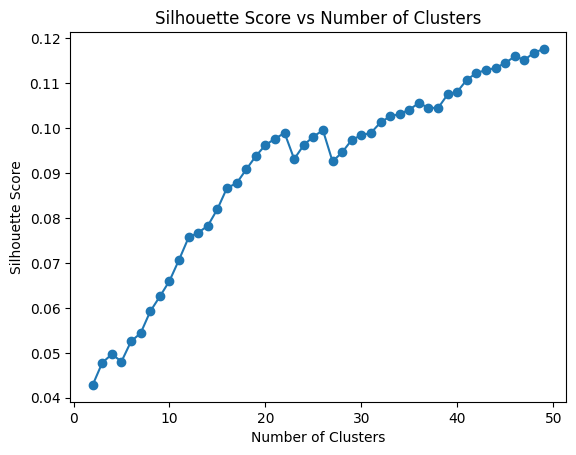

In [73]:
# Choose the optimal number of categories
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Sample embeddings (replace this with your keyword embeddings)
# keyword_embeddings = ...

# Range of cluster numbers to test
range_n_clusters = range(2, 50)  # Test from 2 to 10 clusters
silhouette_scores = []

for n_clusters in range_n_clusters:
    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(keyword_embeddings)
    
    # Calculate silhouette score
    score = silhouette_score(keyword_embeddings, cluster_labels)
    silhouette_scores.append(score)

# Find the optimal number of clusters
optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_clusters}")

# Optional: Plot silhouette scores to visualize
import matplotlib.pyplot as plt
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

Silhouette scores have been really low, which indicates that there is probably no natural clustering. This makes sense as these keywords might be very concentrated on "hurricane" related topic.

In [74]:
# Encode keywords
# keyword_embeddings = model.encode(keywords)

# Apply KMeans clustering
num_categories = 45  # Adjust based on your need
kmeans = KMeans(n_clusters=num_categories, random_state=42).fit(keyword_embeddings)

# Print clustered categories
for cluster in range(num_categories):
    cluster_keywords = [keywords[i] for i in range(len(keywords)) if kmeans.labels_[i] == cluster]
    print(f"Cluster {cluster}: {cluster_keywords}")

Cluster 0: ['neighborhoods crews', 'swannanoa resident', 'mills tennessee', 'mills tenn', 'area gastonia', 'gastonia police', 'colletsville community', 'colletsville nc', 'community colletsville', 'efforts colletsville', 'colletsville', 'town forest', 'center waynesville', 'waynesville center', 'waynesville', 'center waynesville', 'waynesville center', 'waynesville', 'road waynesville', 'canton town', 'citycade looking', 'clyde residents', 'bakersville helen', 'city zachary', 'jefferson florence', 'town council', 'town dentist', 'town forest', 'dentist town', 'library downtown', 'downtown marshall', 'smathers town', 'crest lincolnton', 'crest lincolnton', 'tryon residents', 'tryon town', 'downtown waynesville', 'coming waynesville', 'waynesville campaign', 'come waynesville', 'waynesville smoky', 'gastonia city', 'porvenir community', 'cooper village', 'leary village', 'emma communities', 'assessments waynesville', 'town minneapolis', 'happening barnardsville', 'neighbors davis', 'resi

Test probability clustering with kmeans

In [ ]:
probs.shape

(1679, 40)

In [44]:
from sklearn.cluster import KMeans

# Use topic probabilities as input for clustering
num_clusters = 10  # Choose the number of clusters you want
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(probs)

# Now each article is assigned to a cluster
print(cluster_labels)

[1 1 1 ... 1 1 1]


In [42]:
import pandas as pd

# Create a DataFrame
topic_labels = pd.DataFrame({
    'article': sub_articles['cleaned_text'],
    'topic': topics,
    'cluster': cluster_labels
})

print(topic_labels.head())


                                              article  topic  cluster
0   boone samaritan s purse and alliance bible fel...     14        1
1   attorney general josh stein declared the state...     -1        1
2   widespread power outages due to damage from hu...     -1        1
3   more than 300 line technicians consisting of b...      4        1
12  university of virginia recruit and a c reynold...      0        1


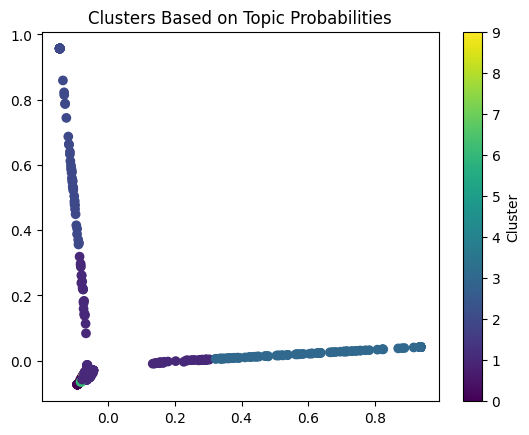

In [45]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_probs = pca.fit_transform(probs)

plt.scatter(reduced_probs[:, 0], reduced_probs[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(label="Cluster")
plt.title("Clusters Based on Topic Probabilities")
plt.show()

##### Gensim

In [ ]:
from gensim import corpora
from gensim.models import LdaModel

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(sub_articles['cleaned_text'])
corpus = [dictionary.doc2bow(tokens) for tokens in sub_articles['cleaned_text']]

# Build the LDA model
lda = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)

# Print topics
topics = lda.print_topics(num_words=5)
for topic in topics:
    print(topic)

### Geographical Mapping

Of newspaper publications & of coverage

In [3]:
# Get a subset of valid articles because we don't have all
sub_articles = articles[articles['word_count'] != '']

# Import geojson data
us_counties = gpd.read_file("https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json")
nc_counties = us_counties[us_counties['STATE'] == '37']     # NC only


In [4]:
# Load the pre-trained spaCy model
nlp = spacy.load('en_core_web_sm')
text = articles['cleaned_article'][0]

# FUNC: find location entity using NER
# Return (List) of locations in text
def ner_location(text):
    doc = nlp(text)
    loc = []
    for ent in doc.ents:
        if ent.label_ == "GPE":  # GPE = Geopolitical Entity
            loc.append(ent.text)
            # print(f"Location identified: {ent.text}")
    return loc

In [5]:
# FUNC: detect if text contains county in c_list
# if so, +1 to the value of that county in c_dict
def detect_place(text, c_list, c_dict):
    if text == "":
        return
    locations = ner_location(text)
    for loc in locations:
        loc = loc.lower().replace(' county','')
        if loc in c_list:
            if loc in c_dict.keys():
                c_dict[loc] +=1
            else:
                c_dict[loc] = 1

#### Publication by county

In [62]:
# Article publication by county
counties = sub_articles.groupby('County')['article'].count().reset_index()

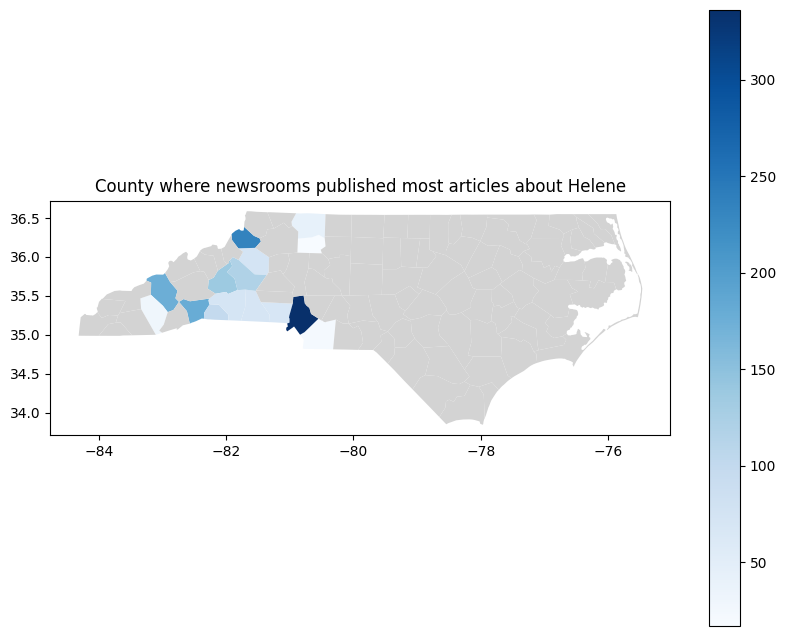

In [14]:
merged = nc_counties.merge(counties, left_on='NAME', right_on='County', how='left')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged.plot(column='article', ax=ax, legend=True, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"})
plt.title("County where newsrooms published most articles about Helene")
plt.show()

#### Coverage by County

In [20]:
# Get coverage by county
county_list = nc_counties.NAME.str.lower().reset_index().NAME.to_list()
# county_list = nc_counties.NAME.to_list()
county_dict = {}
sub_articles['cleaned_article'].apply(lambda x: detect_place(x, county_list, county_dict))
c_df = pd.DataFrame(list(county_dict.items()), columns=['County', 'coverage'])

# Merge
nc_counties['NAME_2'] = nc_counties['NAME'].str.lower()
merged = nc_counties.merge(c_df, left_on='NAME_2', right_on='County', how='left')

/Users/yanans/Desktop/helene_coverage/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [23]:
c_df.sort_values('coverage',ascending=False)

,County,coverage
19,haywood,330
6,buncombe,223
8,mcdowell,210
0,watauga,200
9,henderson,195
...,...,...
59,chatham,1
60,anson,1
26,orange,1
11,pender,1


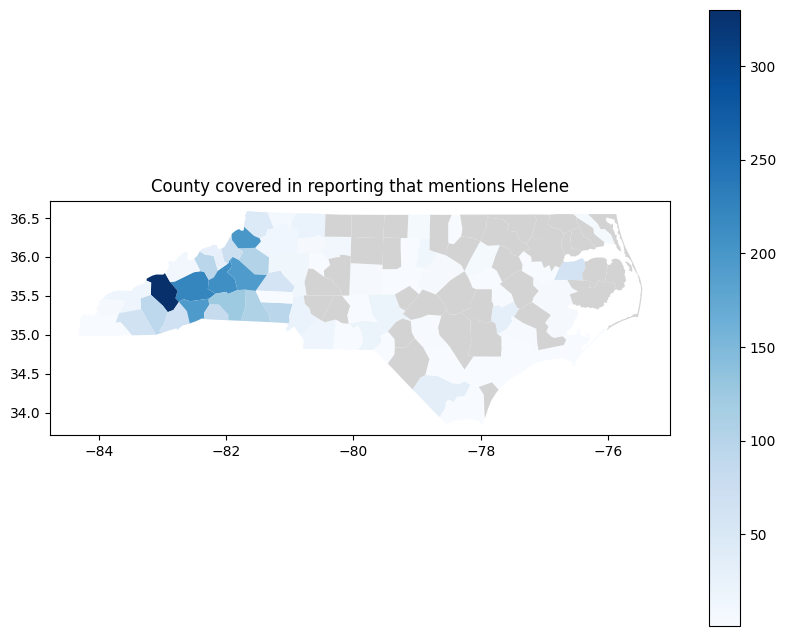

In [22]:
# Make choropleth
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged.plot(column='coverage', ax=ax, legend=True, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"})
plt.title("County covered in reporting that mentions Helene")
plt.show()

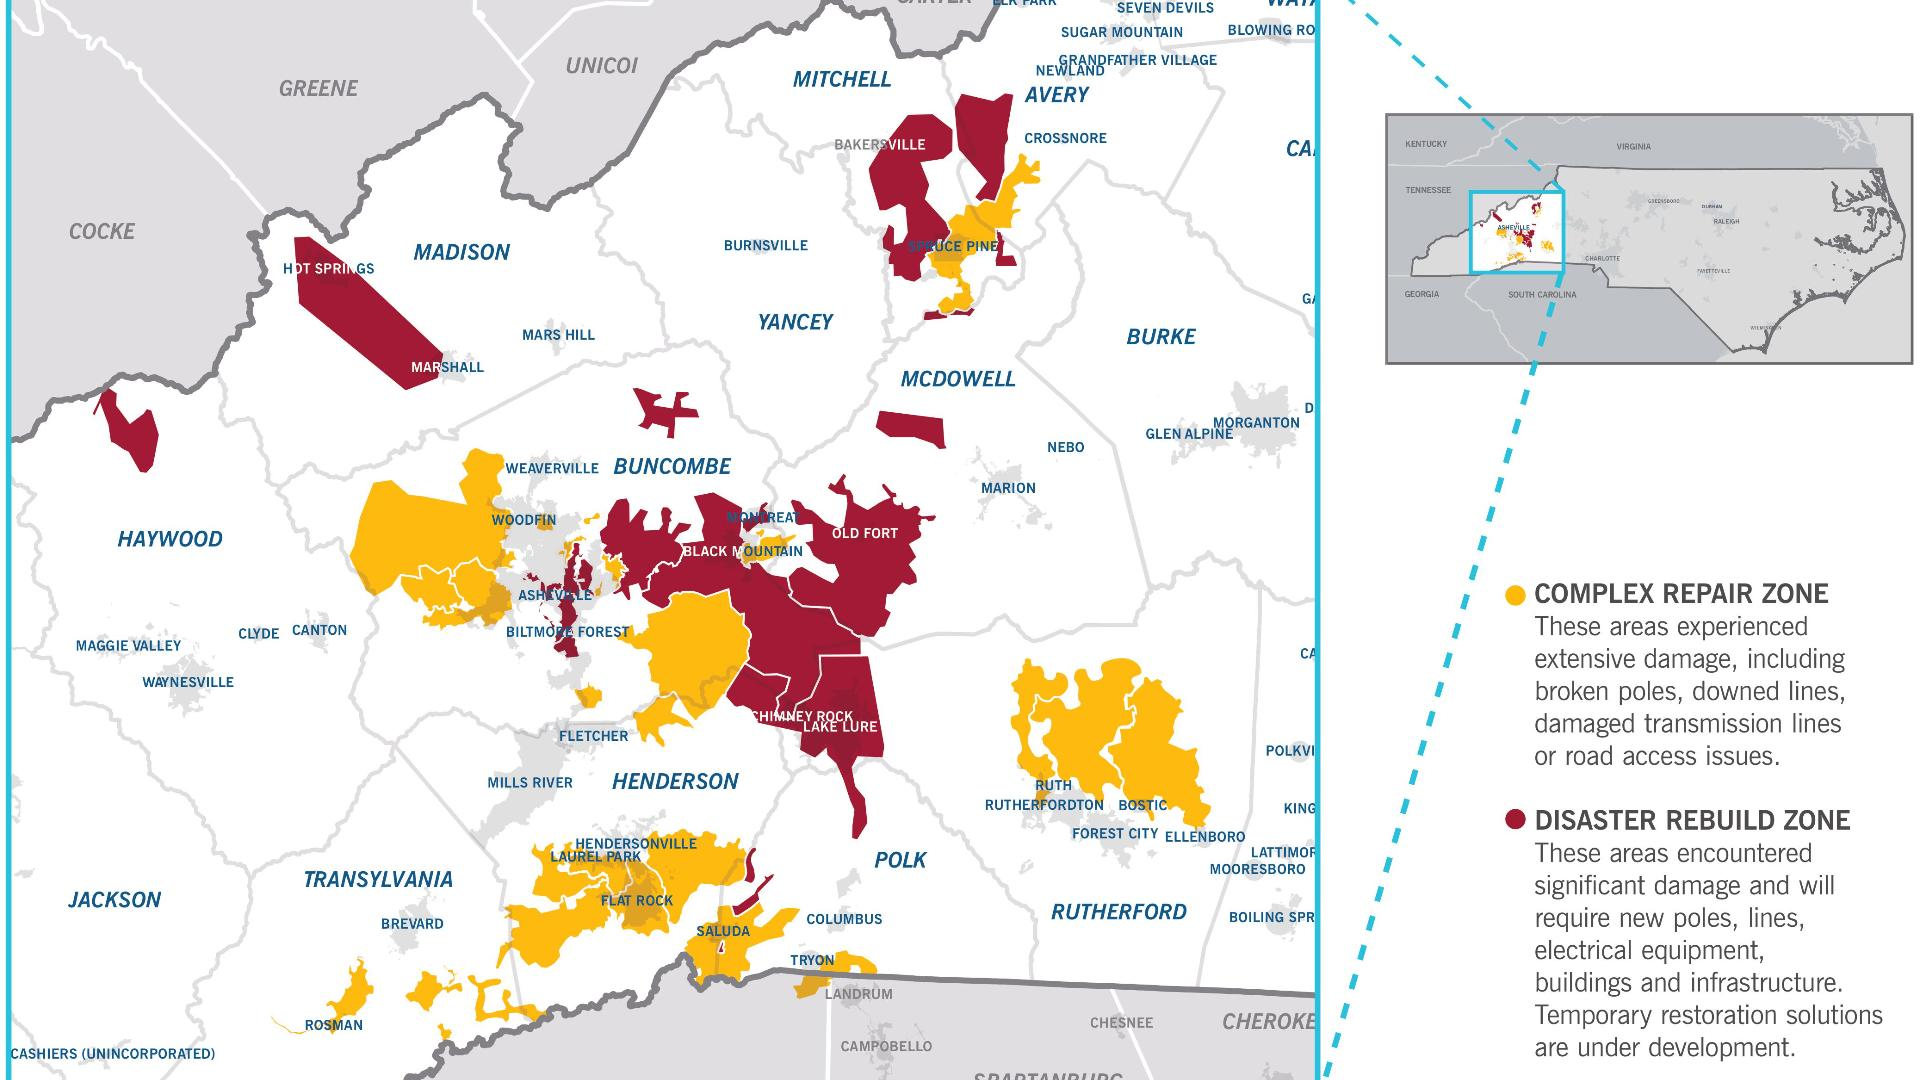

#### Coverage by city

Articles by cities from "helene_county_newsrooms/cities_and_counties.csv"

In [4]:
cities = pd.read_excel('helene_county_newsrooms/cities_and_counties.xlsx')
cities.head()

,City,State short,State full,County,City alias
0,Holtsville,NY,New York,SUFFOLK,Internal Revenue Service
1,Holtsville,NY,New York,SUFFOLK,Holtsville
2,Adjuntas,PR,Puerto Rico,ADJUNTAS,URB San Joaquin
3,Adjuntas,PR,Puerto Rico,ADJUNTAS,Jard De Adjuntas
4,Adjuntas,PR,Puerto Rico,ADJUNTAS,Colinas Del Gigante


In [6]:
nc_cities = cities[cities['State short'] == 'NC']
len(nc_cities)

1616

Can't find geojson files with this granular level.

Find "Munical Boundaries" dataset from <a href = 'https://linc.osbm.nc.gov/explore/dataset/municipal-boundaries-generalized/map/?flg=en-us&disjunctive.municipalb&sort=countyname&location=7,35.46067,-83.05115&basemap=jawg.streets'>NC Office of State Budget and Management</a>

In [24]:
cities = gpd.read_file('helene_county_newsrooms/municipal-boundaries-generalized.geojson')
cities.head()

,municipalb,countyname,countyna_1,countyna_2,countyna_3,division,towncode,year_incorporated,censustype,geo_shape,geo_point_2d,shape_leng,shape_area,geometry
0,Murphy,Cherokee,None,None,None,14,1416,1851,Town,None,"{ ""lon"": -84.028244841167648, ""lat"": 35.092926...",67902.108264,7.225104e+07,"MULTIPOLYGON (((-84.04357 35.07763, -84.04029 ..."
1,Conetoe,Edgecombe,None,None,None,4,0407,1887,Town,None,"{ ""lon"": -77.456940234586284, ""lat"": 35.817687...",18504.093521,9.892982e+06,"POLYGON ((-77.46138 35.81259, -77.46154 35.813..."
2,Weldon,Halifax,None,None,None,4,0442,1843,Town,None,"{ ""lon"": -77.613446140069399, ""lat"": 36.420776...",57017.117724,7.692292e+07,"MULTIPOLYGON (((-77.59733 36.43119, -77.59431 ..."
3,Star,Montgomery,None,None,None,8,0842,1897,Town,None,"{ ""lon"": -79.783059060377383, ""lat"": 35.398671...",41713.942754,3.990855e+07,"POLYGON ((-79.76967 35.4055, -79.77425 35.4055..."
4,Mayodan,Rockingham,None,None,None,7,0715,1899,Town,None,"{ ""lon"": -79.966428519646314, ""lat"": 36.421076...",110228.376254,8.750647e+07,"MULTIPOLYGON (((-79.96747 36.42587, -79.96521 ..."


In [25]:
city_list = cities.municipalb.str.lower().reset_index().municipalb.to_list()
city_dict = {}
sub_articles['cleaned_article'].apply(lambda x: detect_place(x, city_list, city_dict))
c_df = pd.DataFrame(list(city_dict.items()), columns=['municipalb', 'coverage'])
c_df.sort_values('coverage', ascending=False)

,municipalb,coverage
50,charlotte,555
15,asheville,313
37,canton,243
16,hendersonville,229
21,morganton,204
...,...,...
107,cramerton,1
96,archdale,1
103,cary,1
101,grantsboro,1


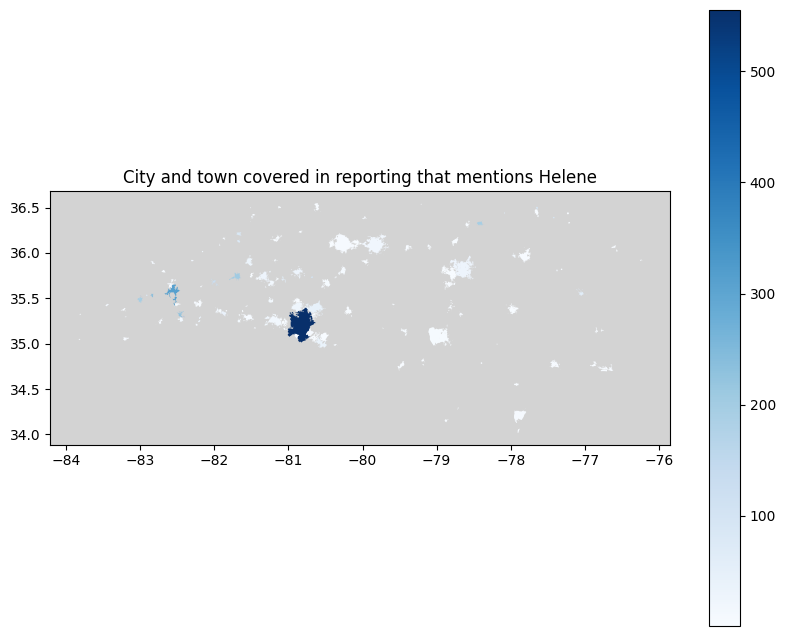

In [26]:
cities['municipalb_2'] = cities['municipalb'].str.lower()
merged = cities.merge(c_df, left_on='municipalb_2', right_on='municipalb', how='left')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged.plot(column='coverage', ax=ax, legend=True, cmap='Blues')
ax.set_facecolor("lightgray")  # Set the map background color

plt.title("City and town covered in reporting that mentions Helene")
plt.show()

#### County publication breakdown by date

In [27]:
county_time = sub_articles.groupby(['County','date'])['article'].count().reset_index()
county_time.head()

,County,date,article
0,Burke,2024-09-25,1
1,Burke,2024-09-26,1
2,Burke,2024-09-27,1
3,Burke,2024-09-29,1
4,Burke,2024-09-30,3


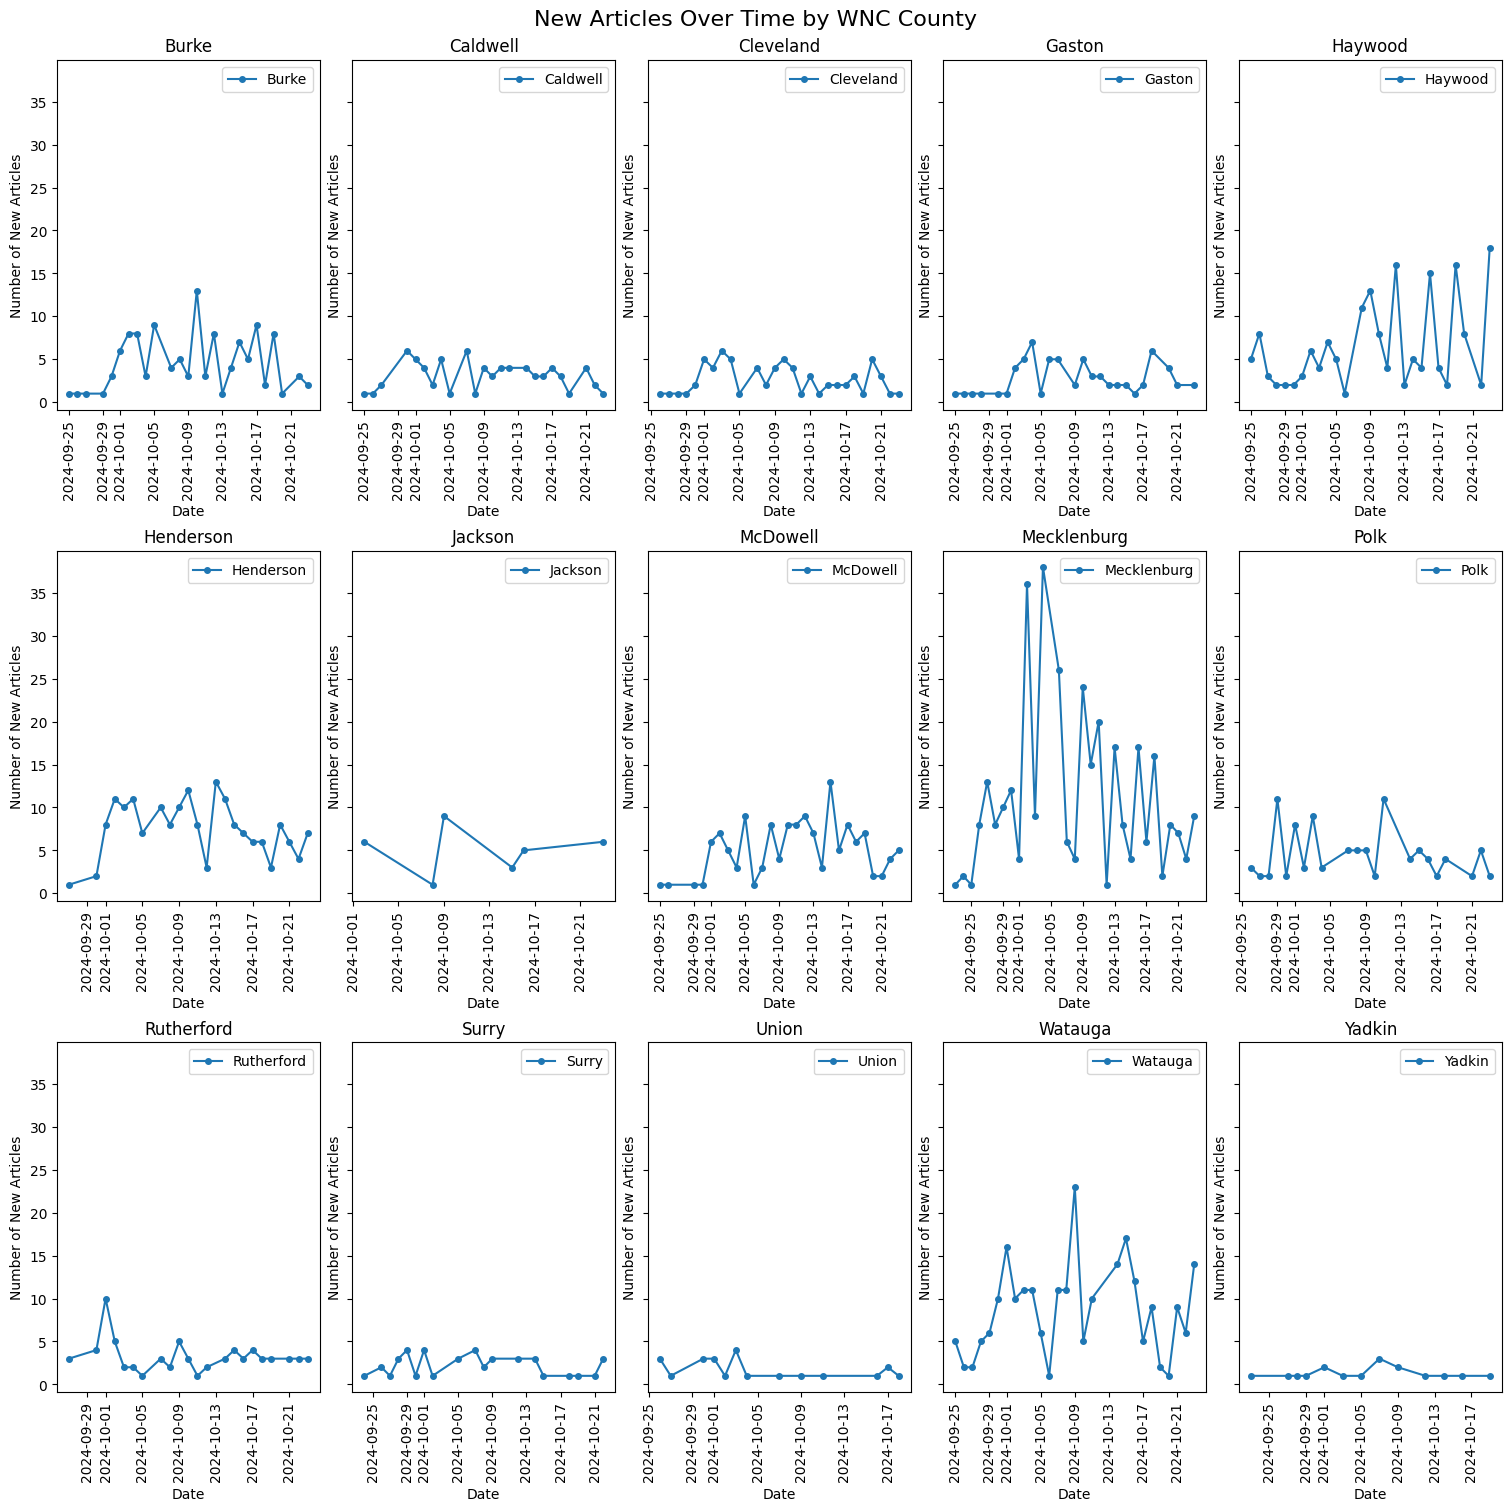

In [28]:
# Group by county
counties = county_time['County'].unique()
n_counties = len(counties)

# Create small multiples
cols = 5  # Number of columns in the grid
rows = (n_counties + cols - 1) // cols  # Calculate rows needed
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True, sharey=True)

# Flatten axes for easy indexing (in case rows * cols > n_counties)
axes = axes.flatten()

# Plot data for each county
for i, county in enumerate(counties):
    ax = axes[i]
    county_data = county_time[county_time['County'] == county]
    ax.plot(county_data['date'], county_data['article'], marker='o', markersize = 4, label=county)
    ax.set_title(county)
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of New Articles")
    ax.tick_params(axis='x', rotation=90)
    ax.legend()

# Remove unused subplots if the number of counties is less than rows * cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("New Articles Over Time by WNC County", fontsize=16)
plt.show()

#### County Coverage Breakdown by Time

In [29]:
beginning = sub_articles[sub_articles['date'] < '2024-10-08']
ending = sub_articles[sub_articles['date'] >= '2024-10-08']

/Users/yanans/Desktop/helene_coverage/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/cn/fww9r0gd1mg20td4q8v12_lsknvlj7/T/ipykernel_31312/639751775.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


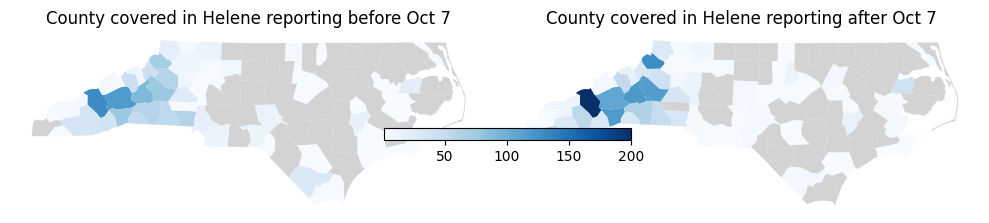

In [30]:
# Get coverage by county
county_list = nc_counties.NAME.str.lower().reset_index().NAME.to_list()
begin, end = {},{}
beginning['cleaned_article'].apply(lambda x: detect_place(x, county_list, begin))
ending['cleaned_article'].apply(lambda x: detect_place(x, county_list, end))
c_df = pd.DataFrame(list(begin.items()), columns=['County', 'coverage'])
c_df_2 = pd.DataFrame(list(end.items()), columns=['County', 'coverage'])

# Merge
nc_counties['NAME_2'] = nc_counties['NAME'].str.lower()
merged = nc_counties.merge(c_df, left_on='NAME_2', right_on='County', how='left')
merged_2 = nc_counties.merge(c_df_2, left_on='NAME_2', right_on='County', how='left')

# Make choropleth
# Determine global color limits
vmin = min(merged['coverage'].min(), merged_2['coverage'].min())
vmax = max(merged['coverage'].max(), merged_2['coverage'].max())

fig, axes = plt.subplots(1, 2, figsize=(10, 8))
merged.plot(column='coverage', ax=axes[0], legend=False, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"}, vmin=vmin, vmax=vmax)
axes[0].set_title("County covered in Helene reporting before Oct 7")
axes[0].axis('off')

merged_2.plot(column='coverage', ax=axes[1], legend=False, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"}, vmin=vmin, vmax=vmax)
axes[1].set_title("County covered in Helene reporting after Oct 7")
axes[1].axis('off')

# Add a shared colorbar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Required for ScalarMappable with no data
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.02, pad=0)

plt.tight_layout()

# plt.title("County covered in reporting that mentions Helene before and after Oct 7")
plt.show()

Week by week?

In [31]:
one = sub_articles[sub_articles['date'] < '2024-09-30']
two = sub_articles[(sub_articles['date'] >= '2024-09-30') & (sub_articles['date'] <= '2024-10-07')]
three = sub_articles[(sub_articles['date'] > '2024-10-07') & (sub_articles['date'] <= '2024-10-15')]
four = sub_articles[(sub_articles['date'] > '2024-10-15') & (sub_articles['date'] <= '2024-10-23')]

/var/folders/cn/fww9r0gd1mg20td4q8v12_lsknvlj7/T/ipykernel_31312/2429238123.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(h_pad=0.5)


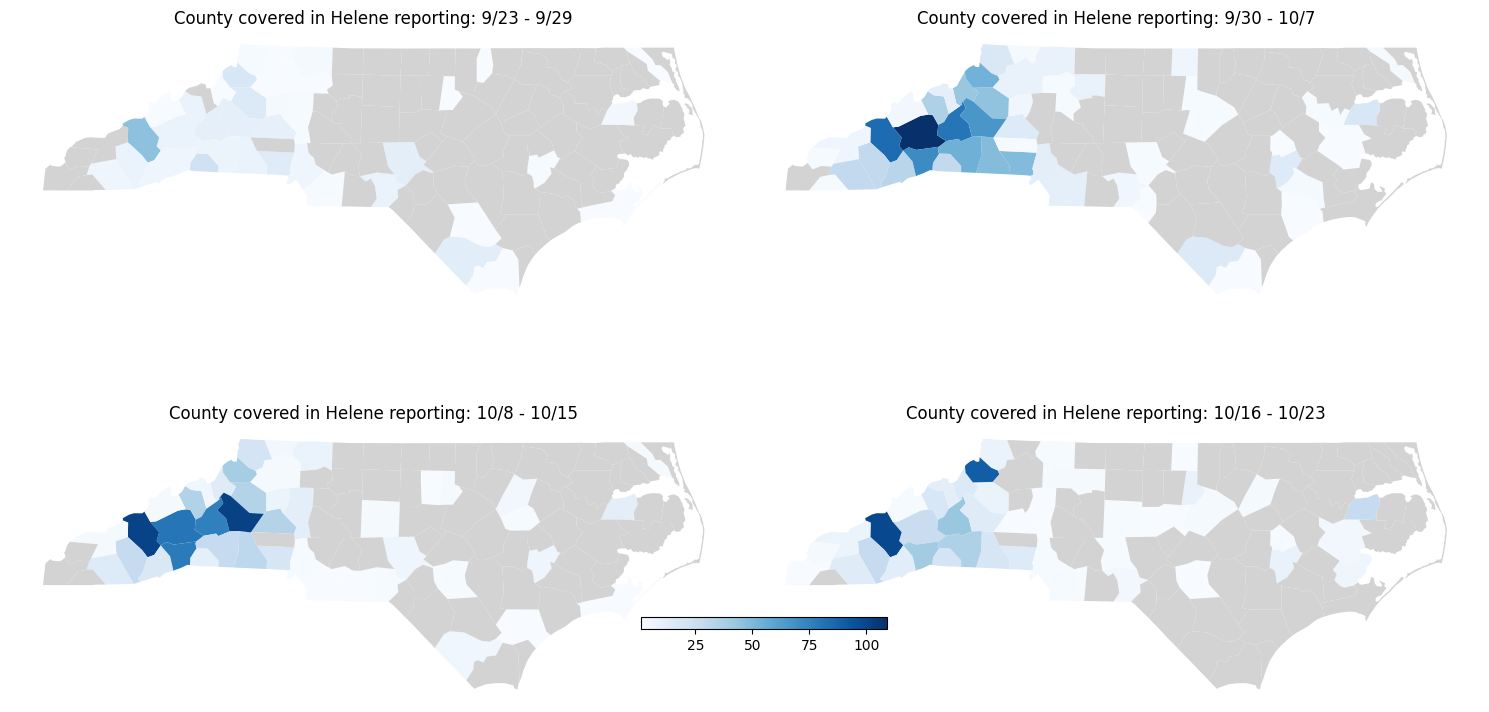

In [ ]:
# Get coverage by county
county_list = nc_counties.NAME.str.lower().reset_index().NAME.to_list()
week1, week2, week3, week4 = {},{},{},{}
one['cleaned_article'].apply(lambda x: detect_place(x, county_list, week1))
two['cleaned_article'].apply(lambda x: detect_place(x, county_list, week2))
three['cleaned_article'].apply(lambda x: detect_place(x, county_list, week3))
four['cleaned_article'].apply(lambda x: detect_place(x, county_list, week4))

c_df = pd.DataFrame(list(week1.items()), columns=['County', 'coverage'])
c_df_2 = pd.DataFrame(list(week2.items()), columns=['County', 'coverage'])
c_df_3 = pd.DataFrame(list(week3.items()), columns=['County', 'coverage'])
c_df_4 = pd.DataFrame(list(week4.items()), columns=['County', 'coverage'])

# Merge
nc_counties['NAME_2'] = nc_counties['NAME'].str.lower()
merged = nc_counties.merge(c_df, left_on='NAME_2', right_on='County', how='left')
merged_2 = nc_counties.merge(c_df_2, left_on='NAME_2', right_on='County', how='left')
merged_3 = nc_counties.merge(c_df_3, left_on='NAME_2', right_on='County', how='left')
merged_4 = nc_counties.merge(c_df_4, left_on='NAME_2', right_on='County', how='left')

# Make choropleth
# Determine global color limits
vmin = min(merged['coverage'].min(), merged_2['coverage'].min(), merged_3['coverage'].min(), merged_4['coverage'].min())
vmax = max(merged['coverage'].max(), merged_2['coverage'].max(), merged_3['coverage'].max(), merged_4['coverage'].max())

fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Flatten the axes for easy access
axes = axes.flatten()

merged.plot(column='coverage', ax=axes[0], legend=False, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"}, vmin=vmin, vmax=vmax)
axes[0].set_title("County covered in Helene reporting: 9/23 - 9/29")
axes[0].axis('off')

merged_2.plot(column='coverage', ax=axes[1], legend=False, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"}, vmin=vmin, vmax=vmax)
axes[1].set_title("County covered in Helene reporting: 9/30 - 10/7")
axes[1].axis('off')

merged_3.plot(column='coverage', ax=axes[2], legend=False, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"}, vmin=vmin, vmax=vmax)
axes[2].set_title("County covered in Helene reporting: 10/8 - 10/15")
axes[2].axis('off')

merged_4.plot(column='coverage', ax=axes[3], legend=False, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"}, vmin=vmin, vmax=vmax)
axes[3].set_title("County covered in Helene reporting: 10/16 - 10/23")
axes[3].axis('off')

# Add a shared colorbar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Required for ScalarMappable with no data
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.02, pad=0.2)

fig.tight_layout(h_pad=0.5)
# plt.title("County covered in reporting that mentions Helene before and after Oct 7")
plt.show()

### Sentiment Analysis

In [102]:
from textblob import TextBlob

def analyze_sentiment(text):
    sentiment = TextBlob(text).sentiment
    return sentiment.polarity

In [104]:
analyze_sentiment(articles['article_text'][0])

0.12356837606837609

In [105]:
sub_articles['polarity'] = sub_articles['article_text'].apply(analyze_sentiment)

In [109]:
def analyze_subjectivity(text):
    sentiment = TextBlob(text).sentiment
    return sentiment.subjectivity

In [110]:
sub_articles['subjectivity'] = sub_articles['article_text'].apply(analyze_subjectivity)

In [75]:
from nrclex import NRCLex

def analyze_emotion(text):
    emotion = NRCLex(text)
    return emotion.raw_emotion_scores

In [77]:
sub_articles['emotions'] = sub_articles['article_text'].apply(analyze_emotion)

Emotion list: fear
anger
anticipation
trust
surprise
positive
negative
sadness
disgust
joy

For each emotion, get its min, max, and median

##### Polarity

In [106]:
sub_articles.groupby('date').mean("polarity")

,polarity
date,
2024-09-23,0.004771
2024-09-24,0.040657
2024-09-25,0.061045
2024-09-26,0.053384
2024-09-27,0.035950
2024-09-28,0.082791
2024-09-29,0.059836
2024-09-30,0.078251
2024-10-01,0.079953


In [111]:
sub_articles.groupby('date').mean("subjectivity")

,polarity,subjectivity
date,,
2024-09-23,0.004771,0.422230
2024-09-24,0.040657,0.442280
2024-09-25,0.061045,0.434332
2024-09-26,0.053384,0.410509
2024-09-27,0.035950,0.370643
2024-09-28,0.082791,0.363957
2024-09-29,0.059836,0.362480
2024-09-30,0.078251,0.372332
2024-10-01,0.079953,0.396699


In [94]:
sub_articles.head()

,header,article,title,date,newspaper,author,word_count,County,Outlet,article_text,cleaned_text,tokens,stemmed_tokens,emotions,polarity
0,"Samaritan’s Purse, Alliance Bible Fellowship e...",BOONE — Samaritan's Purse and Alliance Bible F...,"Samaritan’s Purse, Alliance Bible Fellowship e...",2024-10-02,Watauga Democrat,Luke Barber luke.barber@wataugademocrat.com,593.0,Watauga,Watauga Democrat,BOONE — Samaritan's Purse and Alliance Bible F...,boone samaritan s purse and alliance bible fel...,"[boone, samaritan, purse, fellowship, 1035, hw...","[boon, samaritan, purs, fellowship, 1035, hwi,...","{'trust': 29, 'anger': 7, 'disgust': 5, 'fear'...","(0.12356837606837609, 0.353034188034188)"
1,Watch out for scammers as recovery efforts mov...,Attorney General Josh Stein declared the state...,Watch out for scammers as recovery efforts mov...,2024-10-02,Watauga Democrat,Ben McNeely,379.0,Watauga,Watauga Democrat,Attorney General Josh Stein declared the state...,attorney general josh stein declared the state...,"[stein, gouging, landfall, activated, declares...","[stein, goug, landfal, activ, declar, unreason...","{'trust': 16, 'positive': 20, 'fear': 12, 'neg...","(0.059920634920634916, 0.46970899470899463)"
2,STORM RECOVERY: Carbon Monoxide Safety\nOctobe...,Widespread power outages due to damage from Hu...,STORM RECOVERY: Carbon Monoxide Safety,2024-10-02,Watauga Democrat,Staff Writer,440.0,Watauga,Watauga Democrat,Widespread power outages due to damage from Hu...,widespread power outages due to damage from hu...,"[outages, boone, monoxide, poisoning, applianc...","[outag, boon, monoxid, poison, applianc, gener...","{'anger': 8, 'disgust': 11, 'negative': 22, 's...","(0.08785714285714286, 0.4471596921596923)"
3,Outage restoration continues with more than 40...,More than 300 line technicians consisting of B...,Outage restoration continues with more than 40...,2024-10-02,Watauga Democrat,Moss Brennan moss.brennan@wataugademocrat.com,267.0,Watauga,Watauga Democrat,More than 300 line technicians consisting of B...,more than 300 line technicians consisting of b...,"[technicians, consisting, cooperatives, gradin...","[technician, consist, cooper, grade, categor, ...","{'anger': 4, 'anticipation': 7, 'disgust': 2, ...","(0.10844444444444445, 0.38888888888888895)"
12,Virginia commit Hamrick returning to Crest Hig...,University of Virginia recruit and A.C. Reynol...,Virginia commit Hamrick returning to Crest Hig...,2024-10-10,Gaston Gazette,Joe L Hughes II; Shelby Star,344.0,Gaston,The Gaston Gazette,University of Virginia recruit and A.C. Reynol...,university of virginia recruit and a c reynold...,"[ely, hamrick, crest, crest, crest, asheville,...","[eli, hamrick, crest, crest, crest, ashevil, b...","{'positive': 9, 'trust': 12, 'anticipation': 7...","(0.13415584415584417, 0.37831709956709964)"


##### Emotions

In [78]:
sub_articles['emotions'][0].keys()

dict_keys(['trust', 'anger', 'disgust', 'fear', 'negative', 'sadness', 'surprise', 'anticipation', 'joy', 'positive'])

In [79]:
e_list = ["fear","anger","anticipation","trust","surprise","positive","negative","sadness","disgust","joy"]

def compute_overall_emotions(emotions, mini, maxi, eSum, eCount):
    for emo in emotions.keys():
        loc = e_list.index(emo)
        mini[loc] = min(mini[loc], emotions[emo])
        maxi[loc] = max(maxi[loc], emotions[emo])
        eSum[loc] += emotions[emo]
        eCount[loc] +=1
    # for i in range(10):
    #     eMedian[i] = eSum[i] / eCount[i]
    # emotions_df['mediam'] = emotions_df['sum'] / emotions_df['count']


def compute_df_emotions(df):
    mini, maxi, eSum, eCount, eMedian = [100] *10, [0]*10,[0]*10, [0]*10, [0] * 10
    for index, row in df.iterrows():
        compute_overall_emotions(row['emotions'], mini, maxi, eSum, eCount)
    emotions_df = pd.DataFrame({'emotion': e_list,
                                'minimum': mini,
                                'maximum':maxi, 
                                'sum': eSum, 
                                'count': eCount})
    emotions_df['median'] = emotions_df['sum'] / emotions_df['count']
    return emotions_df


In [80]:
total_emo = compute_df_emotions(sub_articles)
total_emo

,emotion,minimum,maximum,sum,count,median
0,fear,1,95,14992,1568,9.561224
1,anger,1,78,13243,1560,8.489103
2,anticipation,1,144,20168,1609,12.534493
3,trust,1,280,28194,1624,17.360837
4,surprise,1,54,8889,1469,6.051055
5,positive,1,359,46318,1644,28.173966
6,negative,1,172,26434,1623,16.287123
7,sadness,1,88,13996,1582,8.847029
8,disgust,1,45,7678,1426,5.384292
9,joy,1,97,14117,1529,9.232832


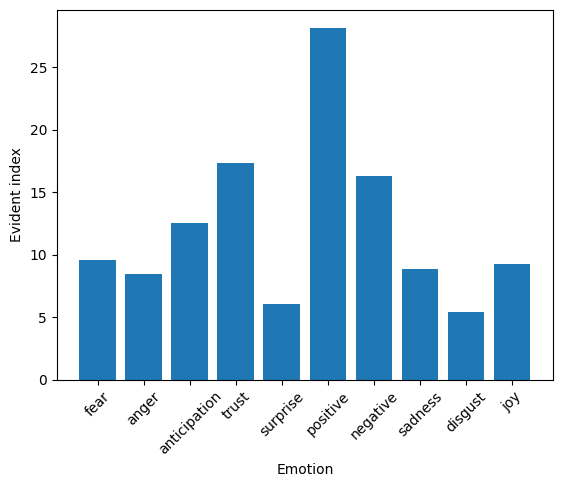

In [81]:
# Plotting the data
plt.bar(total_emo['emotion'], total_emo['median'])
plt.xlabel('Emotion')
plt.ylabel('Evident index')
plt.xticks(rotation=45)

# plt.title('')
plt.show()

In [82]:
# Week by week
one = sub_articles[sub_articles['date'] < '2024-09-30']
two = sub_articles[(sub_articles['date'] >= '2024-09-30') & (sub_articles['date'] <= '2024-10-07')]
three = sub_articles[(sub_articles['date'] > '2024-10-07') & (sub_articles['date'] <= '2024-10-15')]
four = sub_articles[(sub_articles['date'] > '2024-10-15') & (sub_articles['date'] <= '2024-10-23')]

In [83]:
# Compute emotions
one_emo = compute_df_emotions(one).sort_values('median')
two_emo = compute_df_emotions(two).sort_values('median')
three_emo = compute_df_emotions(three).sort_values('median')
four_emo = compute_df_emotions(four).sort_values('median')

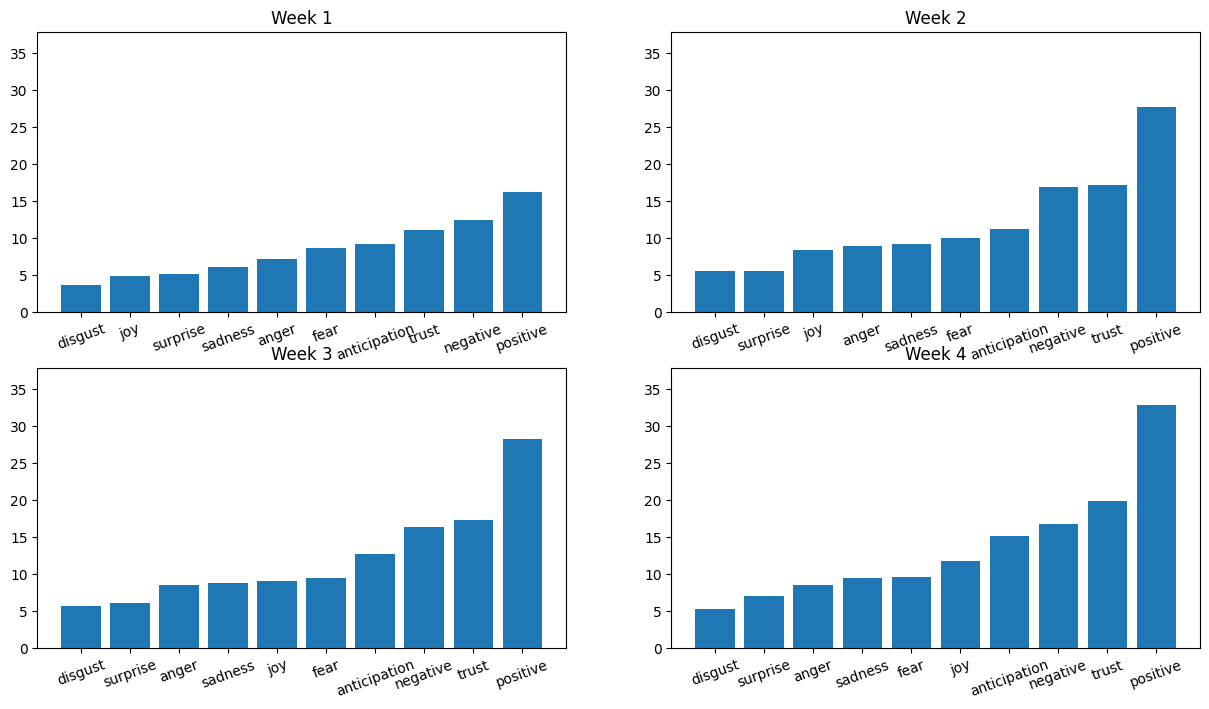

In [86]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# First bar plot
axes[0, 0].bar(one_emo['emotion'], one_emo['median'])
axes[0, 0].set_title('Week 1')

# Second bar plot
axes[0, 1].bar(two_emo['emotion'], two_emo['median'])
axes[0, 1].set_title('Week 2')

# Third bar plot
axes[1, 0].bar(three_emo['emotion'], three_emo['median'])
axes[1, 0].set_title('Week 3')

# Fourth bar plot
axes[1, 1].bar(four_emo['emotion'], four_emo['median'])
axes[1, 1].set_title('Week 4')

# Determine the common limits
x_min = min(one_emo['median'].min(), two_emo['median'].min(), three_emo['median'].min(), four_emo['median'].min())
x_max = max(one_emo['median'].max(), two_emo['median'].max(), three_emo['median'].max(), four_emo['median'].max())
# y_max = max(max(ax.patches[i].get_height() for i in range(len(ax.patches))) for ax in axes.ravel())

for ax in axes.flat:
    ax.tick_params(axis='x', rotation=20)
    # ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, x_max +5)


##### Hugging Face's transfomer

In [88]:
from transformers import pipeline

# Load pre-trained sentiment analysis model
sentiment_pipeline = pipeline("sentiment-analysis")

# Get sentiment predictions
results = sentiment_pipeline(sub_articles['article_text'].to_list())

# Print results
for text, result in zip(sub_articles['article_text'], results):
    print(f"Text: {text}")
    print(f"Sentiment: {result['label']}, Confidence: {result['score']:.2f}")
    print()
    break


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Token indices sequence length is longer than the specified maximum sequence length for this model (790 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The size of tensor a (790) must match the size of tensor b (512) at non-singleton dimension 1

Some (probably many) articles are too long

##### Longformer

In [89]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load Longformer
tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
model = AutoModelForSequenceClassification.from_pretrained("allenai/longformer-base-4096")

# Tokenize the long text
inputs = tokenizer(sub_articles['article_text'][0], truncation=True, padding=True, max_length=4096, return_tensors="pt")

# Get predictions
outputs = model(**inputs)
print(outputs.logits)


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Initializing global attention on CLS token...
Input ids are automatically padded to be a multiple of `config.attention_window`: 512


tensor([[ 0.0748, -0.3287]], grad_fn=<AddmmBackward0>)


In [ ]:
nc_geojson = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"

# Assuming 'value' is linked to county names or FIPS codes
fig = px.choropleth(merged, 
                    geojson=nc_geojson, 
                    locations='municipalb_x', 
                    color='coverage', 
                    featureidkey='properties.NAME',  # Adjust to match GeoJSON property
                    color_continuous_scale="Blues")
# fig.update_geos(fitbounds="locations", visible=False)
# Update geos to show borders
# fig.update_geos(
#     fitbounds="locations",
#     visible=False,
#     showcountries=True,
#     countrycolor="black",  # Black borders
#     showframe=False,
#     showcoastlines=False
# )
fig.update_traces(marker_line_color='black', marker_line_width=0.5)


fig.show()